# Force Optimizations Data Analysis 

In [1]:
from optimization_tools import *
from analysis_tools import *
import matplotlib.pyplot as plt

## Ensemble of Optimizations

First, we perform our initial optimizations using the random (educated) guesses for the weights on the objective function. As these optimizations demand significant computational resources, the code is commented out for the purpose of this example. 

In [2]:
# initial_optimizations()

We next analyze our set of optimizations and parse the data into three DataFrames: `df`, representing the full set of optimizations; `df_filtered`, representing the set of optimizations that passed pre-specified filtering criteria; and `df_pareto1`, representing the set of optimizations on the Pareto front. (This method also exports the Universally Unique Identifiers (unique identifiers for each optimization) of the Pareto front to 
`pareto.txt`). 

In [4]:
df, df_filtered, df_pareto = get_dfs()
# df, df_filtered, df_pareto = get_dfs(inputs="./tests/*/results.json") # REMOVE LATER, remove tests dir too

Let's take a look at our optimizations!

/var/folders/_6/q5y1g_5d74j18s1hfz6jhj2h0000gn/T/ipykernel_1816/1380173541.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pareto_plt(df, df_filtered, df_pareto).show()


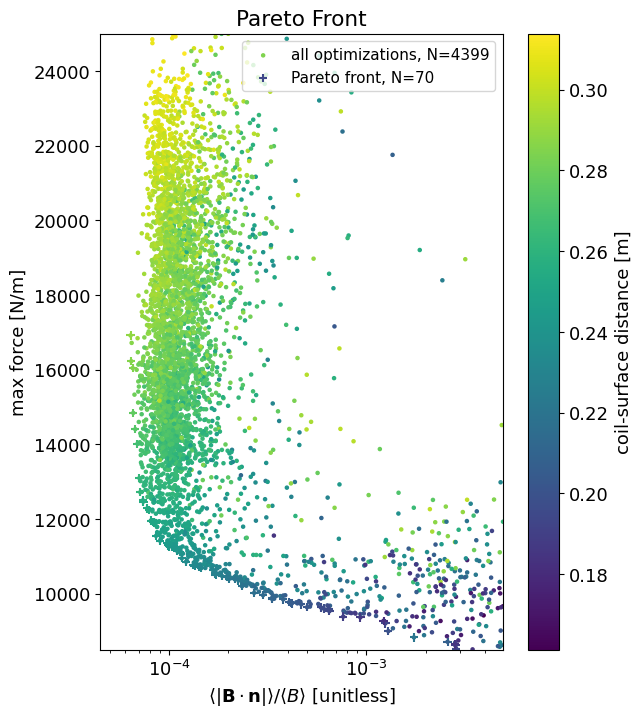

In [5]:
pareto_plt(df, df_filtered, df_pareto).show()

An interesting thing to analyze are the Pearson's R correlations between the maximum force on a coil and other optimization parameters. Interestingly, we see that the strongest correlation by far is with the coil-surface distance. 

In [6]:
print(parameter_correlations(df_filtered, sort_by="max_max_force").to_markdown())

|    | Parameter             |          R |            P |
|---:|:----------------------|-----------:|-------------:|
| 16 | max_max_force         |  1         | 0            |
| 19 | coil_surface_distance |  0.774994  | 0            |
| 11 | force_threshold       |  0.650762  | 0            |
|  9 | cs_threshold          |  0.118535  | 1.86573e-15  |
|  1 | length_target         |  0.101722  | 9.3658e-12   |
| 12 | force_weight          |  0.0725101 | 1.21991e-06  |
| 10 | cs_weight             |  0.0398999 | 0.00763847   |
| 13 | max_length            |  0.029194  | 0.0509973    |
|  4 | max_κ_weight          |  0.0258015 | 0.0845909    |
|  2 | length_weight         |  0.0214328 | 0.151985     |
|  3 | max_κ_threshold       |  0.0105917 | 0.479019     |
|  8 | cc_weight             | -0.0284494 | 0.0572086    |
|  6 | msc_weight            | -0.0398608 | 0.00769807   |
|  5 | msc_threshold         | -0.0407726 | 0.00640991   |
| 15 | max_MSC               | -0.072536  | 1.20926e-06 

### Debugging Tools

Here, we create an interactive plot of the Pareto front. This is particularly useful for identifying specific optimizations visually based on their UUID. 

In [7]:
pareto_interactive_plt(df_pareto).show()

We can also analyze the success of our optimizations in terms of how and how much data was excluded during the filtering step. These plots show histograms of the optimizations with regard to numerous parameters, plotted both before and after filtering.

/var/folders/_6/q5y1g_5d74j18s1hfz6jhj2h0000gn/T/ipykernel_1816/2670730054.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



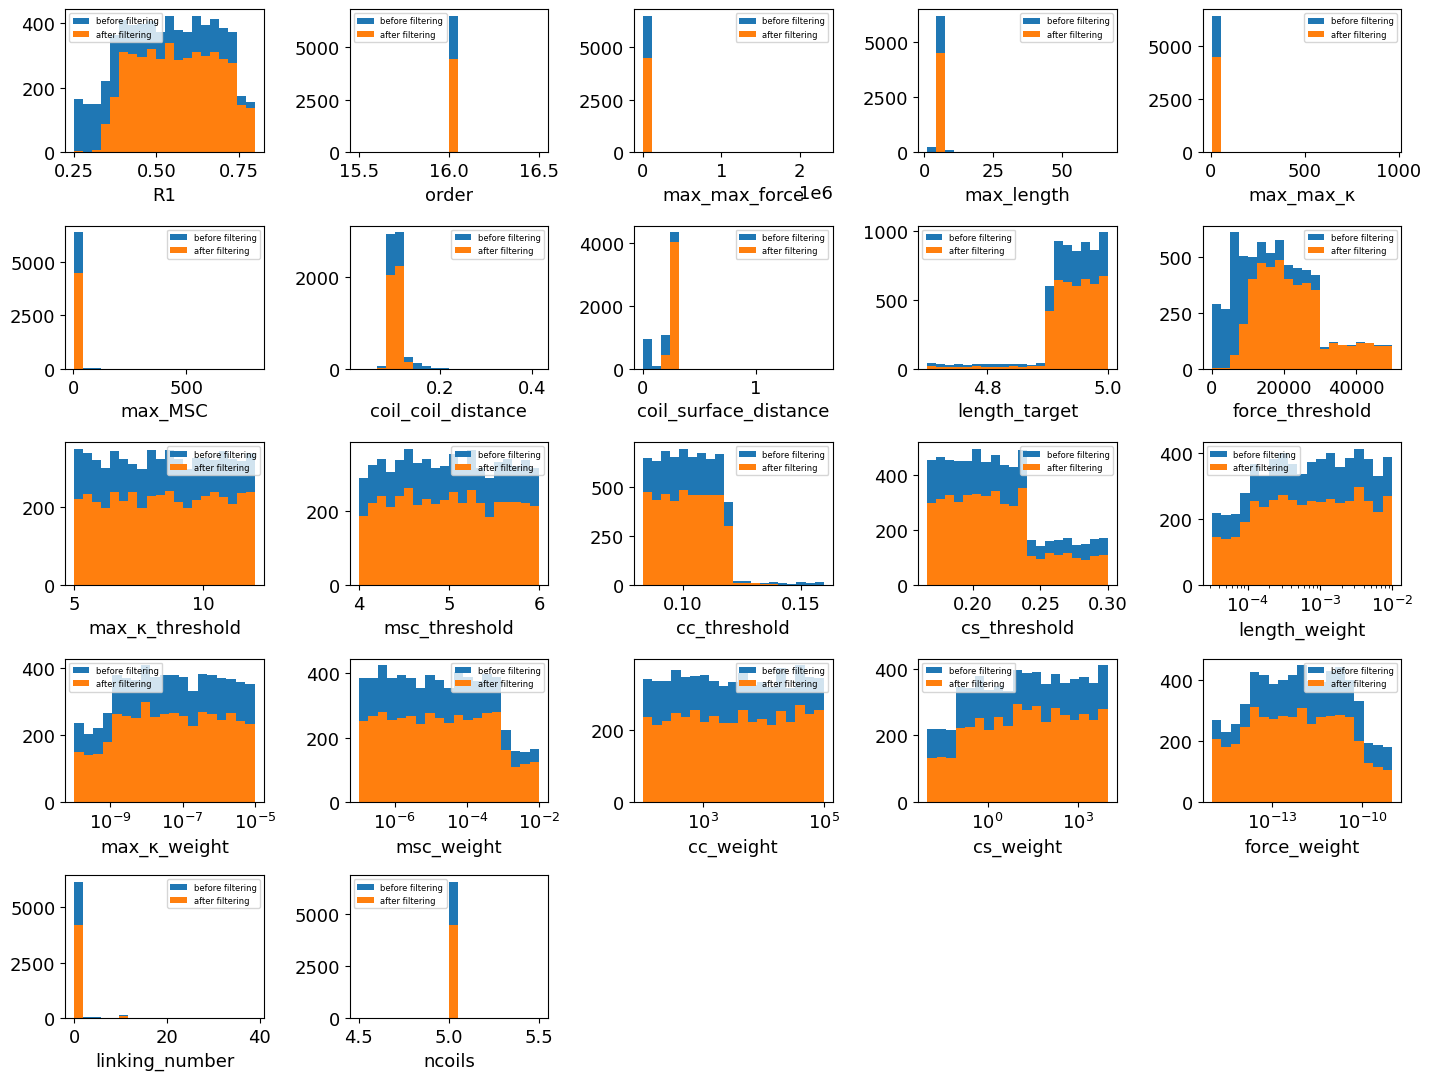

In [8]:
success_plt(df, df_filtered).show()

## Magnetic Field Analysis

Here, we make Poincare plots of the field.

In [9]:
for UUID in ['49d67fc2af7e418a95abd1b56613bf03', '13b5e759418c4d29b5b826acc90f5cb9']:
    image = poincare(UUID, OUT_DIR='1/poincare')
    plt.imshow(image)

./output/1/poincare/49d67fc2af7e418a95abd1b56613bf03/


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcd9099b8b0>>
Traceback (most recent call last):
  File "/Users/sienahurwitz/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
